## Chapter 10. Working W/ Data

### Exploring Your Data
After you’ve IDing questions you’re trying to answer + have gotten some data, might be tempted to dive in + immediately start building models + getting answers --> resist this urge. 

**1st step** = explore your data.

### Exploring One-Dimensional Data

Simplest case = a 1D data set == just a collection of numbers (daily avg. # of minutes each user spends on a site, # of times each of a collection of tutorial videos was watched, # of pages of each book in a library, etc.)

An obvious 1st step = compute a few summary stats = see how many DP's we have, the smallest + largest ones, the mean, + the SD. *But even these don’t necessarily give you a great understanding*. 

A good next step = create a histogram to group data into discrete buckets + count how
many DP's fall into each bucket:

In [1]:
import math

def normal_cdf(x,mu=0,sigma=1):
    return (1+math.erf((x-mu)/math.sqrt(2)/sigma))/2

    # plot some cDFs
    x_ax = [x / 10 for  x in range(-50,50)]
    plt.plot(x_ax, [normal_cdf(x,sigma=1) for x in x_ax], linestyle='-'
             ,label="mu=0, sigma=1")
    plt.plot(x_ax, [normal_cdf(x,sigma=2) for x in x_ax], linestyle='--'
             ,label="mu=0, sigma=2")
    plt.plot(x_ax, [normal_cdf(x,sigma=.5) for x in x_ax], linestyle=':'
             ,label="mu=0, sigma=.5")
    plt.plot(x_ax, [normal_cdf(x,mu=-1) for x in x_ax], linestyle='-.'
             ,label="mu=-1, sigma=1")
    plt.legend(loc=4) # bottom-right
    plt.title("Various Normal CDFs")
    plt.show()

def inverse_normal_cdf(p,mu=0,sigma=1,tolerance=.00001):
    """Find the approximate inverse using binary search"""
    
    # if not standard, standardize and re-scale
    if mu != 0 or sigma != 1:
        return mu + sigma*inverse_normal_cdf(p,tolerance=tolerance)
    
    low_z, low_p = -10.0, 0  # normal_cdf(-10) = very close to 0
    hi_z, hi_p = 10.0, 1     # normal_cdf(10) = very close to 1
    
    while hi_z - low_z > tolerance: 
        mid_z = (low_z + hi_z) / 2 # consider midpoint
        mid_p = normal_cdf(mid_z)  # and the CDF's value there
        
        if mid_p < p:
            # if midpoint is still too low, search above it
            low_z, low_p = mid_z, mid_p
        elif mid_p > p:
            # if midpoint is still too high, search below it
            hi_z, hi_p = mid_z, mid_p 
        else:
            break
    
    return mid_z

In [2]:
%matplotlib inline

import math
import matplotlib.pyplot as plt
from collections import Counter
import random

def bucketize(point,bucket_size):
    """Floor a points to the next lower multiple of bucket_size"""
    return bucket_size*math.floor(point/bucket_size)

def make_histogram(points,bucket_size):
    """Buckets the points + counts how many are in each bucket"""
    return Counter(bucketize(point,bucket_size) for point in points)

def plot_histogram(points,bucket_size,title=""):
    histogram = make_histogram(points,bucket_size)
    plt.bar(list(histogram.keys()),list(histogram.values()),width=bucket_size)
    plt.title(title)
    plt.show()

random.seed(0)

# uniform between -100-100
uniform = [200*random.random()-100 for _ in range(10000)]

# normal with mean 0 and SD 57
normal = [57*inverse_normal_cdf(random.random()) for _ in range(10000)]

Both have means close to 0 + SD's close to 58. However, they have very different distributions = v. different max + min, but even knowing that wouldn’t have been sufficient to understand how they differed.

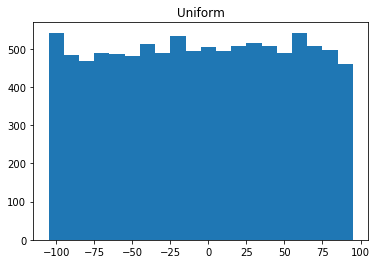

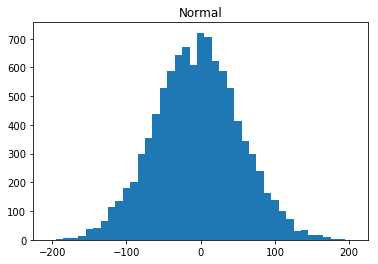

In [3]:
plot_histogram(uniform,10,"Uniform")
plot_histogram(normal,10,"Normal")

### Two Dimensions

Now in addition to daily minutes, we have years of experience. Of course you’d want to understand each dimension individually, but also probably want to scatter the data.
For example, consider another fake data set:

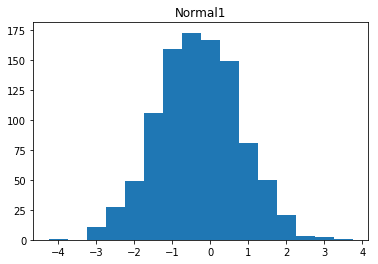

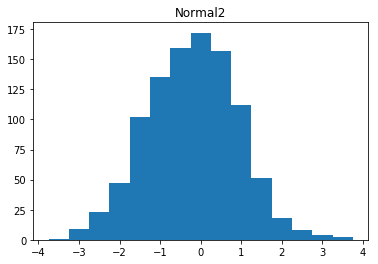

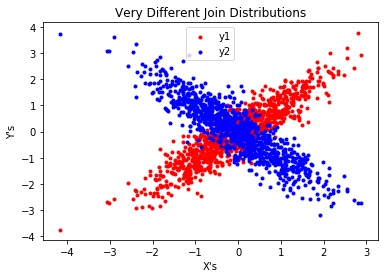

In [4]:
def random_normal():
    """Returns random draw form a Standard Normal Distribution"""
    return inverse_normal_cdf(random.random())

x_ax = [random_normal() for _ in range(1000)]
y_ax1 = [x+random_normal() / 2 for x in x_ax]
y_ax2 = [-x+random_normal() / 2 for x in x_ax]

# both have similar distributions (normal w/ same mean + SD)
plot_histogram(y_ax1,.5,"Normal1")
plot_histogram(y_ax2,.5,"Normal2")

# but different JOINT DISTRIBUTIONS w/ x values
plt.scatter(x_ax, y_ax1, marker='.', color='red', label='y1')
plt.scatter(x_ax, y_ax2, marker='.', color='blue', label='y2')
plt.xlabel("X's")
plt.ylabel("Y's")
plt.legend(loc=9)
plt.title("Very Different Join Distributions")
plt.show()

In [5]:
def dot(v, w):
    """v_1 * w_1 + ... + v_n * w_n"""
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v):
    """v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def mean(x):
    return sum(x) / len(x)

def de_mean(x):
    """translate x by subtracting its mean (so the result has mean 0)"""
    x_bar = mean(x)
    return [x_i - x_bar for x_i in x]

def variance(x):
    """assumes x has at least two elements"""
    n = len(x)
    deviations = de_mean(x)
    return sum_of_squares(deviations) / (n - 1)

def standard_deviation(x):
    return math.sqrt(variance(x))

def covariance(x, y):
    n = len(x)
    return dot(de_mean(x), de_mean(y)) / (n - 1)

def correlation(x, y):
    stdev_x = standard_deviation(x)
    stdev_y = standard_deviation(y)
    if stdev_x > 0 and stdev_y > 0:
        return covariance(x, y) / stdev_x / stdev_y
    else:
        return 0 # if no variation, correlation is zero

# JOINT DISTRIBUTION difference would also be apparent in the correlations
print(correlation(x_ax,y_ax1))
print(correlation(x_ax,y_ax2))

0.9010493686379609
-0.8920981526880033


### Many Dimensions

W/ many dimensions, you’d like to know how ALL the dimensions relate to one another. A simple approach = look @ **correlation matrix**, in which the entry in row i + col j = correlation between the ith dimension and the jth dimension of the data:

In [6]:
def shape(A):
    num_rows = len(A)
    num_cols = len(A[0]) if A else 0
    return num_rows, num_cols

def get_column(A, j):
    return [A_i[j] for A_i in A]

def make_matrix(num_rows, num_cols, entry_fn):
    """returns a num_rows x num_cols matrix
    whose (i,j)-th entry is entry_fn(i, j)"""
    return [[entry_fn(i, j) for j in range(num_cols)]
            for i in range(num_rows)]

def correlation_mtx(data):
    """Returns num_cols*num_cols matrix whose (i,j)th entry
    is the correlation between columns i and j of given data"""
    _, num_columns = shape(data)
    
    def matrix_entry(i,j):
        return correlation(get_column(data,i),get_column(data,j))
    
    return make_matrix(num_columns,num_columns,matrix_entry)

num_points = 100

def random_row():
    row = [None, None, None, None]
    row[0] = random_normal()
    row[1] = -5 * row[0] + random_normal()
    row[2] = row[0] + row[1] + 5 * random_normal()
    row[3] = 6 if row[2] > -2 else 0
    
    return row

random.seed(0)
data = [random_row() for _ in range(num_points)]
correlation_mtx(data)

[[1.0, -0.9811358167114443, -0.6617493801914248, -0.517322308755641],
 [-0.9811358167114445,
  1.0000000000000002,
  0.6818185438510717,
  0.5421152672467888],
 [-0.6617493801914248,
  0.6818185438510717,
  1.0000000000000002,
  0.7461443698023104],
 [-0.517322308755641,
  0.5421152672467889,
  0.7461443698023105,
  0.9999999999999999]]

more visual approach (if you don’t have *too* many dimensions) = make a **scatterplot
matrix** showing all **pairwise scatterplots**. 

To do that, use `plt.subplots()` = allows us to create subplots of our chart given # of
rows + # of columns + returns a **figure object** (not used) + a 2D array of **axes objects** (each of which we’ll plot to):

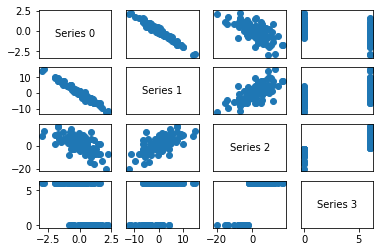

In [7]:
_, num_columns = shape(data)
fix,ax = plt.subplots(num_columns,num_columns)

for i in range(num_columns):
    for j in range(num_columns):
        
        # scatter col_j on x-axis vs. col_i on y-axis
        if i != j:
            ax[i][j].scatter(get_column(data,j),get_column(data,i))
        # unless i ==j, in which case, show series name
        else:
            ax[i][j].annotate("Series " + str(i), (.5,.5),
                              xycoords="axes fraction",
                              ha="center",va="center")
        # then hide axis labels except left + bottom charts
        if i < num_columns - 1:
            ax[i][j].xaxis.set_visible(False)
        if j > 0:
            ax[i][j].yaxis.set_visible(False)            

# Fix bottom right + top left axis labels
#  - wrong b/c charts only have text in them
ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
ax[0][0].set_ylim(ax[0][1].get_ylim())

plt.show()

Looking @ the scatterplots --> series 1 = very negatively correlated w/ series 0, series 2 = positively correlated w/ series 1, + series 3 only takes on values 0 and 6, w/ 0 corresponding to small values of series 2 and 6 corresponding to large values.

This is a quick way to get a rough sense of which of your variables are correlated

### Cleaning and Munging

Real-world data = dirty + we often need to work on it before we can use it.

Less error-prone to do parsing on the way in rather than right before analysis, which we can do by creating functions

In [8]:
##  function to wrap `csv.reader()`, given a list of parsers, each specifying
##    how to parse 1 of the columns, using `None` to represent “don’t do anything to
##    this column”

def parse_row(input_row,parsers):
    """Given a list of parsers (some of which may be None), apply
    appropriate one to each element of the input_row"""
    return [parser(value) if parser is not None else value
           for value,parser in zip(input_row,parsers)]

def parse_rows_with(reader,parsers):
    """Wrap a reader to apply the parsers to each of its rows"""
    for row in reader:
        yield parse_row(row,parsers) 
        # yield returns a generator (a kind iterable we can only iterate over once)
        
# catch bad data (e.g. float that isn't a number) with a helper function
##  to return None instead of crashing the program
def try_or_none(f):
    """Wraps f to return None if f raises an exception, it assumes
    f takes only one input"""
    def f_or_none(x):
        try: return f(x)
        except: return None
    return f_or_none

# now rewrite parse_row to use this catch function
def parse_row(input_row,parsers):
    """Given a list of parsers (some of which may be None), apply
    appropriate one to each element of the input_row"""
    return [try_or_none(parser)(value) if parser is not None else value
           for value,parser in zip(input_row,parsers)]

# read in and parse bad stock market data in single step
import dateutil.parser, csv

data = []
with open("comma_delimited_stock_prices.csv", "r") as f:
    reader = csv.reader(f)
    for line in parse_rows_with(reader, [dateutil.parser.parse, None, float]):
        data.append(line)
      
print(data)

[[datetime.datetime(2014, 6, 20, 0, 0), 'AAPL', 90.91], [datetime.datetime(2014, 6, 20, 0, 0), 'MSFT', 41.68], [datetime.datetime(3014, 6, 20, 0, 0), 'FB', 64.5], [datetime.datetime(2014, 6, 19, 0, 0), 'AAPL', 91.86], [datetime.datetime(2014, 6, 19, 0, 0), 'MSFT', None], [datetime.datetime(2014, 6, 19, 0, 0), 'FB', 64.34]]


In [9]:
# after which check for None rows
for row in data:
    if any(x is None for x in row):
        print(row)

[datetime.datetime(2014, 6, 19, 0, 0), 'MSFT', None]


Then we can decide what we want to about rows containing `None`'s. (Generally speaking, the 3 options = get rid of them, go back to the source + try to fix the bad/missing data, or do nothing + cross fingers.)

We could create similar helpers for csv.`DictReader`. In that case, you’d probably want to supply a `dict` of parsers by field name. For example:

In [10]:
def try_parse_field(field_name,value,parser_dict):
    """Try to parse value using appropriate function from parser_dict"""
    parser = parser_dict.get(field_name) # return None if no such entry
    if parser is not None:
        return try_or_none(parser)(value)
    else:
        return value
    
def parse_dict(input_dict,parser_dict):
    return {field_name: try_parse_field(field_name,value,parser_dict)
           for field_name,value in input_dict.items()}

Good next step = check for outliers, using techniques from previous section "Exploring Your Data” or by ad hoc investigating (ex: 1 of the dates in the stocks file had the year 3014 --> won’t (necessarily) give an error, but it’s plainly wrong + we’ll get screwy results if not caught)

Real-world data sets have missing decimal points, extra 0's, typographical errors, + countless other problems that it’s your job to catch.

### Manipulating Data
1 of the most important skills of a data scientist = **manipulating data** = more of a
general approach than specific technique, so work through a handful of examples to give you the flavor of it.

Imagine we’re working with dicts of stock prices that look like:

In [11]:
import datetime

data = [
    {'closing_price': 102.06,
    'date': datetime.datetime(2014, 8, 29, 0, 0),
    'symbol': 'AAPL'},
    # ...
]

Conceptually we’ll think of them as rows (as in a spreadsheet) + then start asking questions about this data. Along the way we’ll try to notice patterns in what we’re doing + abstract out some tools to make the manipulation easier.

For instance, suppose we want to know the highest-ever closing price for AAPL. Let’s break this down into concrete steps:

* Restrict ourselves to AAPL rows.
* Grab the closing_price from each row.
* Take the max of those prices.

We can do all three at once using a **list comprehension** (concise way to create lists consisting of brackets containing an expression followed by a `for` clause, then
0+ more `for` or `if` clauses resulting in a new list from evaluating the expression in the context of the `for` and `if` clauses which follow it)

In [12]:
map_appl_price = max(row["closing_price"]
                    for row in data
                    if row["symbol"] == "AAPL")
print(map_appl_price)

102.06


In [13]:
with open("stocks.txt", "r", encoding='utf8', newline='') as f:
    reader = csv.DictReader(f, delimiter="\t")
    data = [parse_dict(row, { 'date' : dateutil.parser.parse,
                             'closing_price' : float })
            for row in reader]

print(data)

[{'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 23, 0, 0), 'closing_price': 112.98}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 22, 0, 0), 'closing_price': 112.4}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 21, 0, 0), 'closing_price': 109.55}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 20, 0, 0), 'closing_price': 108.72}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 16, 0, 0), 'closing_price': 105.99}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 15, 0, 0), 'closing_price': 106.82}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 14, 0, 0), 'closing_price': 109.8}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 13, 0, 0), 'closing_price': 110.22}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 12, 0, 0), 'closing_price': 109.25}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 9, 0, 0), 'closing_price': 112.01}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 8, 0, 0), 'closing_price': 111.89}, {'

More generally, might want highest-ever closing price for *each* stock in the data set. One way to do this is:

* Group together all the rows with the same symbol.
* Within each group, do the same as before

In [14]:
from collections import defaultdict
# like a regular dict but when trying to look up a key it doesn’t contain, it first
#   adds a value for it using a 0-argument function  provided when it was created

# group rows by symbol
by_symbol = defaultdict(list)
for row in data:
    by_symbol[row["symbol"]].append(row)
print(by_symbol)

defaultdict(<class 'list'>, {'AAPL': [{'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 23, 0, 0), 'closing_price': 112.98}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 22, 0, 0), 'closing_price': 112.4}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 21, 0, 0), 'closing_price': 109.55}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 20, 0, 0), 'closing_price': 108.72}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 16, 0, 0), 'closing_price': 105.99}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 15, 0, 0), 'closing_price': 106.82}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 14, 0, 0), 'closing_price': 109.8}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 13, 0, 0), 'closing_price': 110.22}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 12, 0, 0), 'closing_price': 109.25}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 9, 0, 0), 'closing_price': 112.01}, {'symbol': 'AAPL', 'date': datetime.datetime(2015, 1, 8

In [15]:
# use dict comprehension to find max for each symbol
max_price_by_symbol = {symbol: max(row["closing_price"]
                                  for row in grouped_rows)
                      for symbol,grouped_rows in by_symbol.items()}
# .iteritems() no longer works, use .items()

print(max_price_by_symbol)

{'AAPL': 119.0, 'MSFT': 49.3, 'FB': 81.45}


There are some patterns here already --> both examples = needed to pull the `closing_price` value out of every `dict`. So let’s create a function to pick a field out of a `dict` + another function to pluck the same field out of a *collection* of dicts:

In [16]:
def picker(field_name):
    """Returns function that picks a field out of a dict"""
    return lambda row: row[field_name]
    
def plucker(field_name,rows):    
    """Turns list of dict's into list of field_name values"""
    return map(picker(field_name),rows) # apply above function to each dictionary

Can also create a function to group rows by the result of a **grouper function** and to optionally apply some sort of **`value_transform`** to each group:

In [17]:
def group_by(grouper,rows,value_transform=None):
    # key = output of given grouper, value = list of given rows
    grouped = defaultdict(list)
    for row in rows:
        grouped[grouper(row)].append(row)
        
    if value_transform is None:
        return grouped
    else:
        return {key:value_transform(rows)
               for key,rows in grouped.items()}

This allows us to rewrite our previous examples quite simply.

In [18]:
max_price_by_symbol = group_by(grouper=picker(field_name="symbol"),
                              rows=data,
                              value_transform=lambda rows:max(plucker(field_name="closing_price",rows=rows)))
print(max_price_by_symbol)

{'AAPL': 119.0, 'MSFT': 49.3, 'FB': 81.45}


Can now start to ask more complicated things, like what are the largest + smallest 1-day % changes in the data set (`% change = (price_today / price_yesterday) - 1`, which means we need some way of associating today’s price + yesterday’s price. 

1 approach = group the prices by symbol, then, within each group:

* Order the prices by date.
* Use `zip` to get pairs (previous, current).
* Turn the pairs into new “percent change” rows.

Start by writing a function to do all the "within-each-group" work:

In [19]:
def percent_price_change(yesterday,today):
    return today["closing_price"] / yesterday["closing_price"] - 1

def day_over_day_changes(grouped_rows):
    # sort rows by date
    ordered = sorted(grouped_rows, key=picker(field_name="date"))
    
    # zip with an offset to get pairs of consecutive days
    return [{"symbol": today["symbol"],
            "date": today["date"],
            "change": percent_price_change(yesterday,today)}
           for yesterday,today in zip(ordered,ordered[1:])]

## Then use value_transform in a group_b
# key = symbol, value = list of "chance" dicts
changes_by_symbol = group_by(grouper=picker(field_name="symbol"),
                            rows=data,
                            value_transform=day_over_day_changes)

print(changes_by_symbol.values())

dict_values([[{'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 15, 0, 0), 'change': -0.045454545454545525}, {'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 16, 0, 0), 'change': -0.0714285714285714}, {'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 17, 0, 0), 'change': 0.025641025641025772}, {'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 18, 0, 0), 'change': 0.02499999999999991}, {'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 19, 0, 0), 'change': 0.07317073170731714}, {'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 22, 0, 0), 'change': 0.045454545454545414}, {'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 23, 0, 0), 'change': 0.04347826086956519}, {'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 24, 0, 0), 'change': 0.04166666666666674}, {'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 26, 0, 0), 'change': 0.10000000000000009}, {'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 29, 0, 0), 'change': 0.0181818181818183}, {'s

In [20]:
# collect all "change" dicts into 1 big list
all_changes = [change
              for changes in changes_by_symbol.values()
              for change in changes]
print(all_changes)

[{'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 15, 0, 0), 'change': -0.045454545454545525}, {'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 16, 0, 0), 'change': -0.0714285714285714}, {'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 17, 0, 0), 'change': 0.025641025641025772}, {'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 18, 0, 0), 'change': 0.02499999999999991}, {'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 19, 0, 0), 'change': 0.07317073170731714}, {'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 22, 0, 0), 'change': 0.045454545454545414}, {'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 23, 0, 0), 'change': 0.04347826086956519}, {'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 24, 0, 0), 'change': 0.04166666666666674}, {'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 26, 0, 0), 'change': 0.10000000000000009}, {'symbol': 'AAPL', 'date': datetime.datetime(1980, 12, 29, 0, 0), 'change': 0.0181818181818183}, {'symbol': 'AAPL

In [21]:
# now it's easy to find largest + smallest
print(max(all_changes,key=picker(field_name="change")))
print(min(all_changes,key=picker(field_name="change")))

{'symbol': 'AAPL', 'date': datetime.datetime(1997, 8, 6, 0, 0), 'change': 0.3283582089552237}
{'symbol': 'AAPL', 'date': datetime.datetime(2000, 9, 29, 0, 0), 'change': -0.5193370165745856}


We can now use `all_changes` data set to find which month is best to invest in tech stocks. 1st, group changes by month + then compute overall change within each group.

Once again, we write an appropriate `value_transform` and then use `group_by`:

In [28]:
from functools import reduce

# to combine % changes, add 1 to each, multiply them, + subtract 1
# ex: if we combine +10% and -20%, overall change = (1+10)*(1-20) - 1 = 1.1*.8-1 = -12
def combine_pct_changes(pct_change1,pct_change2):
    return (1+pct_change1)*(1+pct_change2)-1

def overall_change(changes):
    return reduce(combine_pct_changes, plucker("change", changes))

overall_change_by_mth = group_by(grouper=lambda row: row["date"].month,
                                rows=all_changes,
                                value_transform=overall_change)

print(overall_change_by_mth,"\n")
print(max(overall_change_by_mth.keys()),max(overall_change_by_mth.values()))

{12: 2.2895332950255933, 1: 19.972214514609085, 2: 0.11858483359215, 3: 2.818850048603327, 4: 6.9341967849847626, 5: 1.2555660890321603, 6: -0.5977889232201744, 7: -0.17183091713561482, 8: 6.220055959879489, 9: -0.741162543642831, 10: 21.552541251680015, 11: 3.758572336791725} 

12 21.552541251680015
